# Assignment 7: Estimating Neural Beta using a Multilayer Perceptron (MLP)
- This notebook intentionally uses PyTorch throughout.
- Carefully read each TODO and the hints in comments.
- Follow subsequent steps as indicated by the assignment.

In [4]:
# -------------------------
# Standard imports (PyTorch mandated)
# -------------------------
import math
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Optional
import base64

In [5]:
# -------------------------
# Reproducibility + Device
# -------------------------
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 1. Data Processing (including Step 7)

Please implement **all data processing** in this section, including Step 7. The processing should include (but is not limited to):
- Loading the data
- Creating features
- Performing Train/Validation/Test split

In [6]:
MSF_PATH = "./data/MSF_1996_2023.csv"
FF5_PATH = "./data/F-F_Research_Data_5_Factors_2x3.csv"

TRAIN_START, TRAIN_END = "2005-01-01", "2012-12-31"
VAL_START, VAL_END = "2013-01-01", "2017-12-31"
TEST_START, TEST_END = "2018-01-01", "2023-12-31"


def sic_to_industry_code(sic: float) -> int:
    if pd.isna(sic):
        return 10
    sic = int(sic)
    if 1 <= sic <= 999:
        return 1
    if 1000 <= sic <= 1499:
        return 2
    if 1500 <= sic <= 1799:
        return 3
    if 2000 <= sic <= 3999:
        return 4
    if 4000 <= sic <= 4999:
        return 5
    if 5000 <= sic <= 5199:
        return 6
    if 5200 <= sic <= 5999:
        return 7
    if 6000 <= sic <= 6799:
        return 8
    if 7000 <= sic <= 8999:
        return 9
    if 9000 <= sic <= 9999:
        return 10
    return 10


def load_crsp_msf(msf_path=MSF_PATH):
    df = pd.read_csv(msf_path, low_memory=False)
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"])
    elif "DATE" in df.columns:
        df["date"] = pd.to_datetime(df["DATE"])
    elif "yyyymm" in df.columns:
        df["date"] = pd.to_datetime(df["yyyymm"].astype(str) + "01", format="%Y%m%d")
    else:
        raise ValueError("No recognizable date column in MSF.")

    df["date"] = df["date"].dt.to_period("M").dt.to_timestamp()

    df.columns = [c.lower() for c in df.columns]
    for c in ["ret", "vwretd", "siccd", "permno", "prc", "shrout"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df["industry"] = df["siccd"].apply(sic_to_industry_code)
    df["mktcap"] = df["prc"].abs() * df["shrout"] * 1000.0
    df = df[(df["date"] >= TRAIN_START) & (df["date"] <= TEST_END)].copy()
    df["year"] = df["date"].dt.year
    return df


def sample_firms_per_industry_per_year(df, n_per_ind=10, seed=SEED):
    rng = np.random.default_rng(seed)
    keep = []
    for y, gY in df.groupby("year"):
        for ind, gI in gY.groupby("industry"):
            permnos = gI["permno"].dropna().unique()
            pick = rng.choice(permnos, size=min(n_per_ind, len(permnos)), replace=False)
            keep.extend(pick.tolist())
    return df[df["permno"].isin(set(keep))].copy()


def load_ff5(ff_path="data/F-F_Research_Data_5_Factors_2x3.csv"):
    ff = pd.read_csv(ff_path)
    ff.rename(columns={ff.columns[0]: "date"}, inplace=True)
    ff.columns = [c.lower().strip() for c in ff.columns]
    ff = ff[ff["date"].astype(str).str.match(r"^\d{6}$")]
    ff["date"] = pd.to_datetime(ff["date"].astype(str) + "01", format="%Y%m%d")
    factor_cols = ["mkt-rf", "smb", "hml", "rmw", "cma", "rf"]
    for c in factor_cols:
        ff[c] = pd.to_numeric(ff[c], errors="coerce") / 100.0
    ff = ff[["date"] + factor_cols]
    return ff


def add_lookback_features(msf, w=12, use_ff=False, ff=None):
    df = msf.sort_values(["permno", "date"]).copy()
    if use_ff:
        if ff is None:
            raise ValueError("FF factors required for use_ff=True")
        df = df.merge(ff, on="date", how="left")

    feats = []
    for permno, g in df.groupby("permno"):
        g = g.sort_values("date").copy()
        window = w + 1

        g["roll_ret_mean"] = g["ret"].rolling(window, min_periods=w).mean()
        g["roll_ret_std"] = g["ret"].rolling(window, min_periods=w).std()
        g["roll_mom"] = (
            (1.0 + g["ret"])
            .rolling(window, min_periods=w)
            .apply(lambda x: np.prod(1 + x) - 1, raw=True)
        )
        g["log_mktcap"] = np.log(np.where(g["mktcap"] > 0, g["mktcap"], np.nan))
        g["roll_log_mktcap_mean"] = (
            g["log_mktcap"].rolling(window, min_periods=w).mean()
        )

        r_win, m_win = g["ret"].rolling(window), g["vwretd"].rolling(window)
        cov = (
            ((g["ret"] - r_win.mean()) * (g["vwretd"] - m_win.mean()))
            .rolling(window)
            .mean()
        )
        var_m = ((g["vwretd"] - m_win.mean()) ** 2).rolling(window).mean()
        g["roll_beta_hist"] = cov / var_m

        g["r_next"] = g["ret"].shift(-1)
        g["mkt_next"] = g["vwretd"].shift(-1)

        feats.append(g)

    dfF = pd.concat(feats, ignore_index=True)

    base_feats = [
        "roll_ret_mean",
        "roll_ret_std",
        "roll_mom",
        "roll_log_mktcap_mean",
        "roll_beta_hist",
    ]
    ff_cols = [
        c
        for c in ["mkt-rf", "smb", "hml", "rmw", "cma", "rf"]
        if use_ff and c in dfF.columns
    ]
    feat_cols = base_feats + ff_cols

    dfF = dfF.dropna(subset=feat_cols + ["r_next", "mkt_next"])

    if len(dfF) == 0:
        raise ValueError(
            "No valid samples after feature generation. Try reducing window length w or check FF merge."
        )

    return dfF, feat_cols


def split_by_date(df):
    train = df[(df["date"] >= TRAIN_START) & (df["date"] <= TRAIN_END)].copy()
    val = df[(df["date"] >= VAL_START) & (df["date"] <= VAL_END)].copy()
    test = df[(df["date"] >= TEST_START) & (df["date"] <= TEST_END)].copy()
    return train, val, test


def scale_features(train, val, test, feat_cols):
    scaler = StandardScaler()
    scaler.fit(train[feat_cols])
    for df in [train, val, test]:
        df[feat_cols] = scaler.transform(df[feat_cols])
    return train, val, test, scaler

### Dataset and DataLoader classes

**Dataset:**  
Defines how to access individual samples. It tells PyTorch how to load one data point (features + labels) and how many total samples exist. You need to implement a custom Dataset class here.

**DataLoader:**  
Wraps the Dataset to efficiently provide data during training -- handles batching, shuffling, and parallel loading. Will be used in Step 1.

In [7]:
class NeuralBetaDataset(Dataset):
    """
    Custom dataset that returns:
      x         -> feature vector at time t (shape [D])
      r_next    -> R_{i,t+1}
      mkt_next  -> MKT_{t+1}
    """

    def __init__(self, X, r_next, mkt_next):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.r_next = torch.tensor(r_next, dtype=torch.float32).view(-1, 1)
        self.mkt_next = torch.tensor(mkt_next, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return {
            "x": self.X[idx],
            "r_next": self.r_next[idx],
            "mkt_next": self.mkt_next[idx],
        }

## 2. Neural Beta Estimation

### Step 1

In [8]:
class NeuralBetaMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=64, activation="relu"):
        super().__init__()
        act = {
            "linear": nn.Identity(),
            "sigmoid": nn.Sigmoid(),
            "tanh": nn.Tanh(),
            "relu": nn.ReLU(),
        }[activation.lower()]
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), act, nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)


def neural_beta_rmse(beta_hat, mkt_next, r_next):
    pred = beta_hat * mkt_next
    return torch.sqrt(((pred - r_next) ** 2).mean() + 1e-12)


def train_one_epoch(model, loader, opt):
    model.train()
    total = 0
    n = 0
    for b in loader:
        x = b["x"].to(DEVICE)
        r = b["r_next"].to(DEVICE)
        m = b["mkt_next"].to(DEVICE)
        opt.zero_grad()
        bh = model(x)
        loss = neural_beta_rmse(bh, m, r)
        loss.backward()
        opt.step()
        total += loss.item()
        n += 1
    return total / max(n, 1)


@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total = 0
    n = 0
    for b in loader:
        x = b["x"].to(DEVICE)
        r = b["r_next"].to(DEVICE)
        m = b["mkt_next"].to(DEVICE)
        loss = neural_beta_rmse(model(x), m, r)
        total += loss.item()
        n += 1
    return total / max(n, 1)


def fit(model, train_ds, val_ds, batch_size=256, lr=1e-3, max_epochs=50):
    model.to(DEVICE)
    tr_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    va_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = {"train": [], "val": []}
    for e in range(max_epochs):
        tr = train_one_epoch(model, tr_loader, opt)
        va = evaluate(model, va_loader)
        hist["train"].append(tr)
        hist["val"].append(va)
        print(f"Epoch {e+1:03d} | train={tr:.6f} | val={va:.6f}")
    return {"model": model, "history": hist}

### Step 2

Grid/manual search:
  - Hidden units: e.g., [32, 64, 128]
  - Learning rates: e.g., [1e-2, 1e-3, 3e-4]
  - Activations: ["linear", "sigmoid", "tanh", "relu"]
  - Look-back window w: [12, 24, 36]

In [9]:
def run_grid_search(
    msf_df,
    use_ff=False,
    ff_df=None,
    hidden_list=[32, 64, 128],
    lrs=[1e-2, 1e-3, 3e-4],
    activations=["linear", "sigmoid", "tanh", "relu"],
    windows=[12, 24, 36],
    max_epochs=30,
    batch_size=512,
):
    results = []
    best = {"val": float("inf")}
    for w in windows:
        keep, feat_cols = add_lookback_features(msf_df, w=w, use_ff=use_ff, ff=ff_df)
        train, val, test = split_by_date(keep)
        train, val, test, scaler = scale_features(train, val, test, feat_cols)
        train_ds = NeuralBetaDataset(
            train[feat_cols].to_numpy(),
            train["r_next"].to_numpy(),
            train["mkt_next"].to_numpy(),
        )
        val_ds = NeuralBetaDataset(
            val[feat_cols].to_numpy(),
            val["r_next"].to_numpy(),
            val["mkt_next"].to_numpy(),
        )

        for hd in hidden_list:
            for act in activations:
                for lr in lrs:
                    model = NeuralBetaMLP(len(feat_cols), hd, act)
                    out = fit(model, train_ds, val_ds, batch_size, lr, max_epochs)
                    v = out["history"]["val"][-1]
                    cfg = {
                        "w": w,
                        "hidden": hd,
                        "act": act,
                        "lr": lr,
                        "in_dim": len(feat_cols),
                    }
                    results.append({"cfg": cfg, "val": v})
                    if v < best.get("val", 1e9):
                        best.update(
                            {
                                "val": v,
                                "cfg": cfg,
                                "history": out["history"],
                                "model": model,
                                "feat_cols": feat_cols,
                                "test_df": test,
                            }
                        )
    return best, results

### Step 3

In [10]:
def plot_training(h, title="Training Curves (RMSE)"):
    plt.figure(figsize=(6, 4))
    plt.plot(h["train"], label="train")
    plt.plot(h["val"], label="val")
    plt.title(title)
    plt.xlabel("epoch")
    plt.ylabel("RMSE")
    plt.legend()
    plt.tight_layout()
    plt.show()

### Step 4 & 5

In [11]:
@torch.no_grad()
def predict_betas_df(model, df, feat_cols):
    X = torch.tensor(df[feat_cols].to_numpy(), dtype=torch.float32, device=DEVICE)
    bh = model.to(DEVICE)(X).squeeze(1).cpu().numpy()
    out = df[["permno", "date", "industry", "mktcap", "r_next", "mkt_next"]].copy()
    out["beta_hat"] = bh
    return out


def descriptive_by_industry(df):
    def pct(x):
        return pd.Series(
            {
                "min": x.min(),
                "p01": np.percentile(x, 1),
                "p50": np.median(x),
                "p99": np.percentile(x, 99),
                "max": x.max(),
            }
        )

    s = (
        df.groupby("industry")["beta_hat"]
        .agg(N="count", mean="mean", std="std")
        .reset_index()
    )
    s["skew"] = df.groupby("industry")["beta_hat"].apply(pd.Series.skew).values
    s["kurtosis"] = df.groupby("industry")["beta_hat"].apply(pd.Series.kurt).values
    p = df.groupby("industry")["beta_hat"].apply(pct).reset_index()
    return pd.merge(s, p, on="industry", how="left")


def plot_industry_beta_time_series(df):
    g = df.groupby(["date", "industry"])["beta_hat"].mean().reset_index()
    plt.figure(figsize=(8, 5))
    for ind, gi in g.groupby("industry"):
        plt.plot(gi["date"], gi["beta_hat"], label=f"Ind {ind}", lw=1.2)
    plt.title("Mean Predicted Beta by Industry (Test)")
    plt.xlabel("Date")
    plt.ylabel("Mean β̂")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()

### Step 9 & 10

In [12]:
def form_quintiles_and_returns(df):
    out_ew, out_vw = [], []
    for dt, g in df.groupby("date"):
        g = g.sort_values("beta_hat").copy()
        if g["beta_hat"].nunique() < 5:
            g["bucket"] = pd.cut(
                g["beta_hat"], bins=5, labels=[1, 2, 3, 4, 5], duplicates="drop"
            )
        else:
            g["bucket"] = pd.qcut(
                g["beta_hat"], 5, labels=[1, 2, 3, 4, 5], duplicates="drop"
            )
        ew = g.groupby("bucket")["r_next"].mean()
        vw = g.groupby("bucket").apply(
            lambda z: np.sum(z["r_next"] * z["mktcap"] / z["mktcap"].sum())
        )
        row_e = {"date": dt, **{f"Q{i}": ew.get(i, np.nan) for i in range(1, 6)}}
        row_v = {"date": dt, **{f"Q{i}": vw.get(i, np.nan) for i in range(1, 6)}}
        row_e["Q5minusQ1"] = row_e["Q5"] - row_e["Q1"]
        row_v["Q5minusQ1"] = row_v["Q5"] - row_v["Q1"]
        out_ew.append(row_e)
        out_vw.append(row_v)
    return pd.DataFrame(out_ew).sort_values("date"), pd.DataFrame(out_vw).sort_values(
        "date"
    )

### Main

In [13]:
def full_run(use_ff=False, grid_epochs=20, batch_size=512, n_per_ind=10):
    msf = load_crsp_msf()
    msf_small = sample_firms_per_industry_per_year(msf, n_per_ind)
    ff = load_ff5() if use_ff else None
    best, res = run_grid_search(
        msf_small, use_ff, ff, max_epochs=grid_epochs, batch_size=batch_size
    )
    print("Best cfg:", best["cfg"], "| Best val RMSE:", best["val"])
    plot_training(best["history"], "Best Config Training Curves (RMSE)")
    test_pred = predict_betas_df(best["model"], best["test_df"], best["feat_cols"])
    desc = descriptive_by_industry(test_pred)
    print("\n=== Descriptive stats by industry ===\n", desc)
    plot_industry_beta_time_series(test_pred)
    EW, VW = form_quintiles_and_returns(test_pred)
    print("\n=== Quintile EW returns (TEST) ===\n", EW.tail())
    print("\n=== Quintile VW returns (TEST) ===\n", VW.tail())
    return {
        "best": best,
        "grid_results": res,
        "test_predictions": test_pred,
        "desc_by_industry": desc,
        "EW": EW,
        "VW": VW,
    }

Epoch 001 | train=0.151909 | val=0.131958
Epoch 002 | train=0.149869 | val=0.131912
Epoch 003 | train=0.150840 | val=0.132011
Epoch 004 | train=0.149731 | val=0.132019
Epoch 005 | train=0.150015 | val=0.132093
Epoch 006 | train=0.150094 | val=0.131920
Epoch 007 | train=0.149900 | val=0.132030
Epoch 008 | train=0.149747 | val=0.131903
Epoch 009 | train=0.150298 | val=0.131957
Epoch 010 | train=0.151312 | val=0.131954
Epoch 011 | train=0.149723 | val=0.131959
Epoch 012 | train=0.151321 | val=0.131933
Epoch 013 | train=0.150302 | val=0.131996
Epoch 014 | train=0.150303 | val=0.131892
Epoch 015 | train=0.149668 | val=0.131958
Epoch 001 | train=0.162046 | val=0.134124
Epoch 002 | train=0.153606 | val=0.132538
Epoch 003 | train=0.150476 | val=0.132059
Epoch 004 | train=0.150756 | val=0.132034
Epoch 005 | train=0.150095 | val=0.132007
Epoch 006 | train=0.149905 | val=0.131994
Epoch 007 | train=0.149654 | val=0.131966
Epoch 008 | train=0.150391 | val=0.132033
Epoch 009 | train=0.150086 | val=0

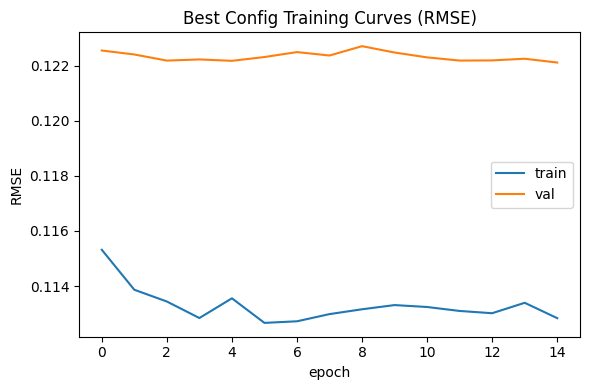


=== Descriptive stats by industry ===
     industry     N      mean       std      skew  kurtosis level_1  beta_hat
0          1   388  1.064298  0.348989  0.396828  0.231309     min  0.369219
1          1   388  1.064298  0.348989  0.396828  0.231309     p01  0.399375
2          1   388  1.064298  0.348989  0.396828  0.231309     p50  1.030095
3          1   388  1.064298  0.348989  0.396828  0.231309     p99  2.056118
4          1   388  1.064298  0.348989  0.396828  0.231309     max  2.143666
5          2  3868  1.609671  0.482739  0.278260 -0.015095     min  0.510257
6          2  3868  1.609671  0.482739  0.278260 -0.015095     p01  0.643043
7          2  3868  1.609671  0.482739  0.278260 -0.015095     p50  1.583685
8          2  3868  1.609671  0.482739  0.278260 -0.015095     p99  2.893517
9          2  3868  1.609671  0.482739  0.278260 -0.015095     max  3.123044
10         3  2384  1.376309  0.258877 -0.420114  0.843513     min  0.374982
11         3  2384  1.376309  0.2588

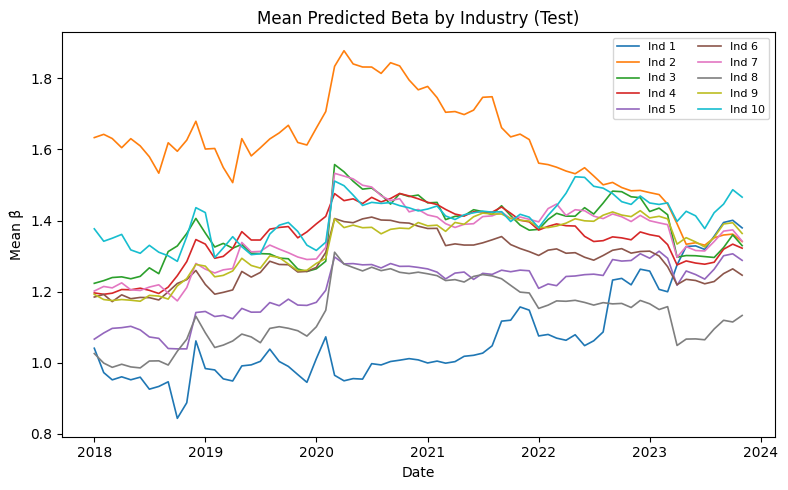

/var/folders/rx/4mtzy3y13t9f2njmm29j60pm0000gp/T/ipykernel_14641/2211583349.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ew = g.groupby("bucket")["r_next"].mean()
/var/folders/rx/4mtzy3y13t9f2njmm29j60pm0000gp/T/ipykernel_14641/2211583349.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vw = g.groupby("bucket").apply(
/var/folders/rx/4mtzy3y13t9f2njmm29j60pm0000gp/T/ipykernel_14641/2211583349.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future


=== Quintile EW returns (TEST) ===
          date        Q1        Q2        Q3        Q4        Q5  Q5minusQ1
66 2023-07-01 -0.034803 -0.041870 -0.022624 -0.051132 -0.105596  -0.070793
67 2023-08-01 -0.035781 -0.059511 -0.037670 -0.063229 -0.112861  -0.077080
68 2023-09-01 -0.018726 -0.024931 -0.042316 -0.050540 -0.098919  -0.080193
69 2023-10-01  0.049980  0.079798  0.066860  0.086527  0.110480   0.060500
70 2023-11-01  0.071907  0.124567  0.073312  0.127473  0.175834   0.103927

=== Quintile VW returns (TEST) ===
          date        Q1        Q2        Q3        Q4        Q5  Q5minusQ1
66 2023-07-01 -0.035770 -0.029004 -0.024620 -0.030107  0.014700   0.050471
67 2023-08-01 -0.023274 -0.030908 -0.038363 -0.061342 -0.107054  -0.083781
68 2023-09-01  0.014579 -0.031561  0.042671 -0.050491 -0.055535  -0.070114
69 2023-10-01  0.043435  0.068153  0.112843  0.101762  0.143136   0.099701
70 2023-11-01  0.009861  0.062619  0.016398  0.119864  0.078215   0.068353
Epoch 001 | train=0.152983

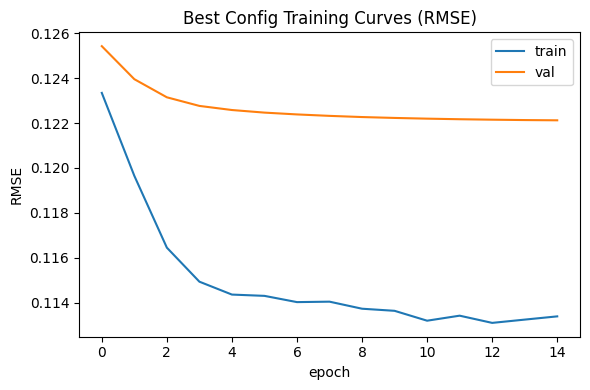


=== Descriptive stats by industry ===
     industry     N      mean       std      skew  kurtosis level_1  beta_hat
0          1   388  0.957928  0.163652  1.294846  2.752728     min  0.550497
1          1   388  0.957928  0.163652  1.294846  2.752728     p01  0.605368
2          1   388  0.957928  0.163652  1.294846  2.752728     p50  0.925446
3          1   388  0.957928  0.163652  1.294846  2.752728     p99  1.490938
4          1   388  0.957928  0.163652  1.294846  2.752728     max  1.585923
5          2  3868  1.248418  0.395456  1.272721  0.664640     min  0.635594
6          2  3868  1.248418  0.395456  1.272721  0.664640     p01  0.854003
7          2  3868  1.248418  0.395456  1.272721  0.664640     p50  1.057011
8          2  3868  1.248418  0.395456  1.272721  0.664640     p99  2.391693
9          2  3868  1.248418  0.395456  1.272721  0.664640     max  2.601520
10         3  2384  1.086095  0.240485  1.498883  1.694113     min  0.644873
11         3  2384  1.086095  0.2404

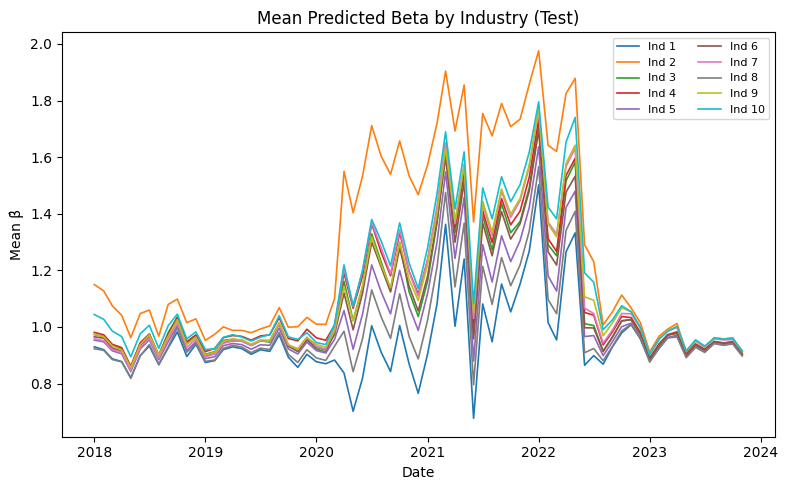


=== Quintile EW returns (TEST) ===
          date        Q1        Q2        Q3        Q4        Q5  Q5minusQ1
66 2023-07-01 -0.035389 -0.031655 -0.022762 -0.055835 -0.110345  -0.074956
67 2023-08-01 -0.043212 -0.055080 -0.058381 -0.069956 -0.082367  -0.039155
68 2023-09-01 -0.019510 -0.038251 -0.048892 -0.057056 -0.071869  -0.052359
69 2023-10-01  0.070353  0.097414  0.091144  0.065381  0.069533  -0.000820
70 2023-11-01  0.063324  0.104112  0.138348  0.113718  0.153820   0.090496

=== Quintile VW returns (TEST) ===
          date        Q1        Q2        Q3        Q4        Q5  Q5minusQ1
66 2023-07-01 -0.030748 -0.022847  0.018750 -0.046610 -0.085063  -0.054316
67 2023-08-01 -0.037648 -0.052903 -0.099214 -0.063486 -0.071986  -0.034339
68 2023-09-01  0.014538 -0.042963 -0.072888 -0.043938 -0.056226  -0.070763
69 2023-10-01  0.089458  0.123346  0.090563  0.015605  0.037106  -0.052353
70 2023-11-01  0.011960  0.089471  0.099257  0.078696  0.169493   0.157533


/var/folders/rx/4mtzy3y13t9f2njmm29j60pm0000gp/T/ipykernel_14641/2211583349.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ew = g.groupby("bucket")["r_next"].mean()
/var/folders/rx/4mtzy3y13t9f2njmm29j60pm0000gp/T/ipykernel_14641/2211583349.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vw = g.groupby("bucket").apply(
/var/folders/rx/4mtzy3y13t9f2njmm29j60pm0000gp/T/ipykernel_14641/2211583349.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future

In [14]:
out = full_run(use_ff=False, grid_epochs=15, batch_size=1024, n_per_ind=10)
out_ff = full_run(use_ff=True, grid_epochs=15, batch_size=1024, n_per_ind=10)

### HTML

In [25]:
def dump_to_html(out_dict, save_dir="data/neural_beta_outputs", plots_dir="plots"):
    Path(save_dir).mkdir(parents=True, exist_ok=True)

    desc = out_dict.get("desc_by_industry")
    EW = out_dict.get("EW")
    VW = out_dict.get("VW")
    best_cfg = out_dict["best"]["cfg"]
    grid_results = pd.DataFrame(out_dict["grid_results"])

    pd.set_option("display.html.use_mathjax", False)

    style = """
    <style>
        body {
            font-family: 'Segoe UI', Roboto, Helvetica, Arial, sans-serif;
            margin: 40px;
            color: #222;
            background-color: #fafafa;
        }
        h1, h2, h3 {
            color: #004080;
            border-bottom: 2px solid #e0e0e0;
            padding-bottom: 4px;
        }
        table {
            border-collapse: collapse;
            width: 100%;
            margin: 12px 0 30px 0;
            font-size: 14px;
        }
        th, td {
            border: 1px solid #ccc;
            padding: 6px 10px;
            text-align: right;
            color: #222;
        }
        th {
            background-color: #004080;
            color: white;
        }
        tr:nth-child(even) {
            background-color: #f5f5f5;
        }
        tr:hover {
            background-color: #e8f0fe;
        }
        a {
            color: inherit;
            text-decoration: none;
            pointer-events: none;
        }
        .meta {
            font-size: 13px;
            color: #666;
        }
        .metric {
            background: #e6f3ff;
            border-left: 4px solid #004080;
            padding: 8px 12px;
            margin: 8px 0 18px 0;
            font-size: 15px;
        }
        .plot-block {
            text-align: center;
            margin: 30px 0;
        }
        .plot-block img {
            max-width: 90%;
            border: 1px solid #ccc;
            border-radius: 8px;
            box-shadow: 0 2px 8px rgba(0,0,0,0.15);
        }
        .plot-title {
            color: #004080;
            font-weight: 500;
            margin-bottom: 6px;
        }
    </style>
    """

    html = [
        f"<!DOCTYPE html><html><head><meta charset='utf-8'><title>Neural Beta Report</title>{style}</head><body>"
    ]
    html.append(f"<h1>Neural Beta Project Report</h1>")

    html.append("<h2>Model Summary</h2>")
    html.append(
        "<div class='metric'><b>Best configuration:</b> "
        + ", ".join([f"{k}={v}" for k, v in best_cfg.items()])
        + f"<br><b>Validation RMSE:</b> {out_dict['best']['val']:.6f}</div>"
    )

    html.append("<h2>Top 20 Grid Search Results</h2>")
    html.append(
        grid_results.sort_values("val")
        .head(20)
        .to_html(
            index=False, border=0, escape=False, float_format=lambda x: f"{x:,.6f}"
        )
    )

    html.append("<h2>Descriptive Statistics by Industry (Test Sample)</h2>")
    html.append(
        desc.to_html(index=False, escape=False, float_format=lambda x: f"{x:,.4f}")
    )

    html.append("<h2>Equal-Weighted Quintile Returns (Last 10 Months)</h2>")
    html.append(
        EW.tail(10).to_html(
            index=False, escape=False, float_format=lambda x: f"{x:,.4f}"
        )
    )
    html.append("<h2>Value-Weighted Quintile Returns (Last 10 Months)</h2>")
    html.append(
        VW.tail(10).to_html(
            index=False, escape=False, float_format=lambda x: f"{x:,.4f}"
        )
    )

    plot_dir = Path(plots_dir)
    if plot_dir.exists():
        html.append("<h2>Plots</h2>")
        for plot_path in sorted(plot_dir.glob("*.png")):
            with open(plot_path, "rb") as f:
                encoded = base64.b64encode(f.read()).decode()
            html.append(
                f"""
            <div class='plot-block'>
                <div class='plot-title'>{plot_path.stem.replace('_',' ').title()}</div>
                <img src='data:image/png;base64,{encoded}' alt='{plot_path.name}'/>
            </div>
            """
            )

    html_output = "\n".join(html)

    html_path = Path(save_dir) / "neural_beta_report.html"
    with open(html_path, "w", encoding="utf-8") as f:
        f.write(html_output)

    return str(html_path)

In [26]:
report_path = dump_to_html(out_ff)
print("Open:", report_path)

Open: data/neural_beta_outputs/neural_beta_report.html
